In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.options.display.max_columns = 500

In [94]:
df.to_csv('FE_fights', index=False)

# Feature Egineering 
### - Create time from last fight✅
### - ordinal encode Max_round  ✅
### - HomeTown will be logitude latitude 

In [54]:
df = pd.read_csv('FE_fights')
df.tail()

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,Date,Event_ID,Fight_ID,Last_round,Max_round,RPrev,R_Age,R_Height,R_HomeTown,R_ID,R_Location,R_Name,R_Weight,winby,winner,avg_weight_lbs,weight_class,B_diff,R_diff
2228,7,0,34.0,172.0,"El Paso, Texas United States",1137,"Coconut Creek, Florida United States",Nik Lentz,70.0,10/08/2018,887,7440,2,3,5,39.0,172.0,"Phoenix, Arizona United States",374,"Las Vegas, Nevada United States",Gray Maynard,65.0,KO/TKO,blue,148.5,Featherweight,128,76
2229,9,1,31.0,177.0,"Milwaukee, Wisconsin United States",1069,"Milwaukee, Wisconsin United States",Anthony Pettis,70.0,10/08/2018,887,7447,2,3,9,34.0,180.0,"Oxnard, California United States",1815,"Orange County, California United States",Tony Ferguson,70.0,KO/TKO,red,154.0,Featherweight,88,304
2230,5,3,35.0,180.0,Amazonas Brazil,2101,Rio de Janeiro Brazil,Alan Patrick,70.0,10/08/2018,887,7448,3,3,6,35.0,175.0,"Knoxville , Tennessee United States",2558,"Knoxville , Tennessee United States",Scott Holtzman,70.0,KO/TKO,red,154.0,Featherweight,916,300
2231,1,0,37.0,170.0,"Moses Lake, Washington United States",1200,"Houston, Texas United States",Tonya Evinger,61.0,10/08/2018,887,7462,1,3,1,23.0,167.0,"Folsom, California United States",2893,"El Dorado Hills, California United States",Aspen Ladd,61.0,KO/TKO,red,134.2,Flyweight,0,0
2232,0,0,23.0,190.0,"Los Angeles, California United States",3072,"Fontana, California United States",Jalin Turner,70.0,10/08/2018,887,7508,1,3,8,26.0,180.0,"Westwood, New Jersey United States",2588,Brasília Brasil,Vicente Luque,77.0,KO/TKO,red,161.7,Lightweight,0,80


## Ordinal Encoding ✅

In [86]:
# Ordinal encoded max rounds as 3_round, 4_round, 5_round
dummies = pd.get_dummies(df.Max_round)
ex = dummies.rename(columns={3:'3_round', 4:'4_round', 5:'5_round'})
cdf = df.copy()
df = cdf.join(ex)

In [93]:
# Destroy max_round column and BStreak because Red does not have that feature
# df = df.drop(columns=['Max_round'])
# df = df.drop(columns=['BStreak'])

In [92]:
df.head()

,BPrev,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,Date,Event_ID,Fight_ID,Last_round,RPrev,R_Age,R_Height,R_HomeTown,R_ID,R_Location,R_Name,R_Weight,winby,winner,avg_weight_lbs,weight_class,B_diff,R_diff,3_round,4_round,5_round
0,0,38.0,193.0,Hounslow England,808,Amsterdam The Netherlands,Alistair Overeem,120.0,02/03/2014,646,4580,3,0,39.0,190.0,"Las Vegas, Nevada USA",377,"Las Vegas, Nevada USA",Frank Mir,119.0,DEC,blue,262.9,Cruiserweight,0,0,1,0,0
1,0,36.0,172.0,"Chicago, Illinois United States",1054,"Chicago, Illinois United States",Ricardo Lamas,65.0,02/03/2014,646,4589,5,0,32.0,170.0,Manaus Brazil,1052,Rio de Janeiro Brazil,Jose Aldo,65.0,DEC,red,143.0,Bantamweight,0,0,0,0,1
2,0,39.0,167.0,"Isla Vista , California USA",959,"Sacramento, California USA",Urijah Faber,61.0,02/03/2014,646,4590,1,0,31.0,167.0,Natal Brazil,1527,Rio de Janeiro Brazil,Renan Barao,61.0,KO/TKO,red,134.2,Flyweight,0,0,0,0,1
3,0,33.0,167.0,"San Diego, CA USA",1056,"San Diego, CA USA",Danny Martinez,56.0,02/03/2014,646,4605,3,0,37.0,160.0,"San Jose, California USA",1253,"Tucson, Arizona USA",Chris Cariaso,56.0,DEC,red,123.2,Strawwweight,0,0,1,0,0
4,0,36.0,185.0,Southampton England,2005,Southampton England,Tom Watson,84.0,02/03/2014,646,4631,3,0,37.0,182.0,"Englewood, NJ USA",464,"Brick, NJ USA",Nick Catone,84.0,DEC,red,184.8,Super Welterweight,0,0,1,0,0


## Create time since last fight ✅
- group each fighter (need to group so that both corners are looked at for time line)
- order based on date
- use an array the size of the data set
- replace none values to the index of that fighter 
- do this for each corner

In [25]:
date = pd.to_datetime(df.Date)
df.Date = date
date.iloc[0]

Timestamp('2014-02-03 00:00:00')

In [26]:
R_group = df.groupby('R_ID')
# len(R_group.groups)
R_group.groups

{129: Int64Index([526, 1102], dtype='int64'),
 175: Int64Index([447, 650, 878], dtype='int64'),
 235: Int64Index([496, 976, 1455], dtype='int64'),
 272: Int64Index([162], dtype='int64'),
 283: Int64Index([190, 429], dtype='int64'),
 295: Int64Index([851, 1307, 1476, 1568, 2085], dtype='int64'),
 305: Int64Index([1146], dtype='int64'),
 306: Int64Index([179, 253, 445], dtype='int64'),
 308: Int64Index([116, 393, 1050, 1221, 1660, 1732, 1775, 1982], dtype='int64'),
 326: Int64Index([172, 589, 694, 912, 1047, 1257, 1528, 1827, 2067], dtype='int64'),
 328: Int64Index([800, 970], dtype='int64'),
 346: Int64Index([12, 465, 558, 747, 1926], dtype='int64'),
 347: Int64Index([1267], dtype='int64'),
 348: Int64Index([579], dtype='int64'),
 356: Int64Index([287, 724], dtype='int64'),
 361: Int64Index([1625], dtype='int64'),
 366: Int64Index([364, 716], dtype='int64'),
 367: Int64Index([208, 814, 1210, 1438, 1592, 2030, 2177], dtype='int64'),
 368: Int64Index([141, 296, 570, 770, 1306, 1794, 1810]

In [27]:
B_group = df.groupby('B_ID')
B_group.groups

{129: Int64Index([128, 161, 638, 851, 1306], dtype='int64'),
 197: Int64Index([120, 271], dtype='int64'),
 219: Int64Index([615], dtype='int64'),
 235: Int64Index([1147], dtype='int64'),
 272: Int64Index([692], dtype='int64'),
 295: Int64Index([660, 1046], dtype='int64'),
 306: Int64Index([693], dtype='int64'),
 308: Int64Index([670], dtype='int64'),
 326: Int64Index([40, 1622], dtype='int64'),
 328: Int64Index([1210], dtype='int64'),
 330: Int64Index([507, 890], dtype='int64'),
 346: Int64Index([239, 1826, 2085], dtype='int64'),
 347: Int64Index([510, 1002, 1449], dtype='int64'),
 356: Int64Index([64], dtype='int64'),
 361: Int64Index([220, 1497], dtype='int64'),
 366: Int64Index([485, 1625], dtype='int64'),
 367: Int64Index([356, 662, 916, 1079, 1819, 1943], dtype='int64'),
 368: Int64Index([443, 976, 1091], dtype='int64'),
 372: Int64Index([248, 416, 674, 863, 1052, 1568], dtype='int64'),
 375: Int64Index([62, 1035], dtype='int64'),
 377: Int64Index([537, 814, 1012], dtype='int64'),

In [28]:
129 in R_group.groups

True

In [29]:
R_i = R_group.indices[129].tolist()

In [30]:
B_i = B_group.indices[129].tolist()
R_i + B_i

[526, 1102, 128, 161, 638, 851, 1306]

In [31]:
df.iloc[R_group.indices[129]]

,BPrev,BStreak,B_Age,B_Height,B_HomeTown,B_ID,B_Location,B_Name,B_Weight,Date,Event_ID,Fight_ID,Last_round,Max_round,RPrev,R_Age,R_Height,R_HomeTown,R_ID,R_Location,R_Name,R_Weight,winby,winner,avg_weight_lbs,weight_class
526,3,0,33.0,187.0,Tehran Iran,786,"Leiden, Holland The Netherlands",Gegard Mousasi,84.0,2015-01-27,702,5132,1,3,2,48.0,180.0,"Downey, California USA",129,"Temecula, California USA",Dan Henderson,84.0,KO/TKO,blue,184.8,Super Welterweight
1102,3,0,40.0,175.0,Matanzas Cuba,768,"Matanzas, Cuba United States",Hector Lombard,84.0,2017-02-13,774,6108,2,3,5,48.0,180.0,"Downey, California USA",129,"Temecula, California USA",Dan Henderson,84.0,KO/TKO,red,184.8,Super Welterweight


In [32]:
R_delta = np.empty(df.shape[0], dtype=pd.Timestamp)
B_delta = np.empty(df.shape[0], dtype=pd.Timestamp)

- iterate through all fighter IDs
- Use ID to get the Red corner and Blue corners into variables
- Create a data frame for each fighter containing the date of the fight and whether which corner they were in and the index and 
- Iterate through the dataframe and create a time delta from last match column
- Add that to corresponding index and corresponding array

In [33]:
# Create list of all IDs
IDs = pd.concat([df.R_ID, df.B_ID])
IDs = IDs.drop_duplicates()

In [34]:
# Create column names for empty DataFrame
columns = ['corner', 'Date', 'diff', 'index'] #, 'index']

In [35]:
for ID in IDs:
    temp_df = pd.DataFrame(columns=columns)
    
    if ID in R_group.groups:
        r_corner = ['r'] * len(R_group.groups[ID])
        r_date = df.iloc[R_group.groups[ID]].Date.tolist()
        r_index = R_group.indices[ID].tolist()
        
    if ID in B_group.groups:
        b_corner = ['b'] * len(B_group.groups[ID])
        b_date = df.iloc[B_group.groups[ID]].Date.tolist()
        b_index = B_group.indices[ID].tolist()
    
    temp_df['corner'] = r_corner + b_corner
    temp_df['Date'] = r_date + b_date
    temp_df['index'] = r_index + b_index
    temp_df = temp_df.sort_values(by=['Date'])
    temp_df['diff'] = temp_df['Date'].diff().fillna(pd.to_timedelta(0))
    
#     print(temp_df.head())

    for _, row in temp_df.iterrows():
        if row.corner == 'r':
            R_delta[row['index']] = row['diff']

        elif row['corner'] == 'b':
            B_delta[row['index']] = row['diff']
    

In [50]:
type([x.days for x in B_delta][1])

int

In [51]:
df['B_diff'] = [x.days for x in B_delta]
df['R_diff'] = [x.days for x in R_delta]

In [37]:
pd.Series(sorted(df.iloc[[1, 20, 50]].Date)).diff()

0       NaT
1   18 days
2   13 days
dtype: timedelta64[ns]

In [70]:
c = ['r'] * 10
c2 = ['b'] * 3
c3 = c + c2
# dfdf = pd.DataFrame({'corner':c3})
# dfdf
c3

['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'b', 'b']

In [55]:
df.R_diff.dtype

dtype('int64')

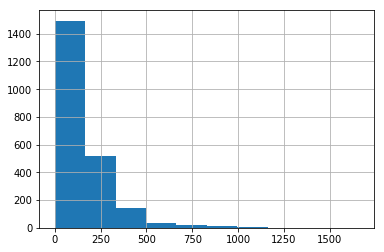

In [58]:
df.B_diff.hist();

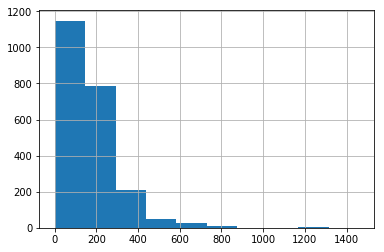

In [60]:
df.R_diff.hist()

## Vectorize names with word to vec
 - I don't think this will work because there's already an ID

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec

In [ ]:
names = df.head().B_Name.values

In [ ]:
names

In [ ]:
tokens = [word_tokenize(x) for x in names]
tokens

In [ ]:
[Word2Vec(x) for x in tokens]

## Use Geopy to add longitude and latitude based off HomeTown

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='pwalis', timeout=3)
location = geolocator.geocode("Brazil", addressdetails=True)


In [ ]:
one = location


In [ ]:
import time
start = time.process_time()
[geolocator.geocode(x) for x in df.R_HomeTown.head(30)]
print(time.process_time() - start)

In [ ]:
R_geo = []
i = 0
for x in df.R_HomeTown:
    i+=1
    print(i)
    geo_info = geolocator.geocode(x)
    R_geo.append(geo_info)
# honestly I just want a green square

A lot of places aren't getting recognized as a location I should look into how the api expects the input
Research how to handle different errors 
if statements based on the error, If it can't get the location info add an entry into the dict that has the hometown string

In [ ]:
from geopy.exc import GeocoderTimedOut
i = 0
R_geo = dict()
for x in df.R_HomeTown:
    i+=1 
    try:
        location = geolocator.geocode(x).raw
        R_geo.update({i:location})
    except Exception as e:
        print("Error: geocode failed on input %s with message %s"%(x, e))
        

In [ ]:
len(R_geo)

In [ ]:
i=0
while i<1162:
    i+=1
    if len(R_geo[i])<10:
        print(R_geo[i])
        

In [ ]:
R_geo.keys()